# <i class="fa-solid fa-square-check"></i> Model Selection

In neurocognitive psychology, we often collect huge amounts of data — sometimes thousands of measurements from different brain regions or many behavioral scores. Having more information can, in theory, help us make better predictions, but it also brings risks: too many variables can make analyses infeasible, lead to false discoveries, or cause models to learn noise instead of real effects. 


## The large p issue

**Big data** refers to large data sets with many predictors which often cannot be processed or analyzed using traditional data processing techniques. For our prediction models, this brings some issues:

- While the linear model can in theory still be used for such data, the **ordinary least squares fit becomes infeasible**, especially when p > n 
- The large amount of features reduce interpretability


This is where **linear model selection** becomes essential, offering techniques to refine our models and extract meaningful insights from high-dimensional data.


## Today's data: Hitters

For practical demonstration, we will use the `Hitters` dataset. This dataset provides Major League Baseball Data from the 1986 and 1987 seasons. It contains 322 observations of major league players on 20 variables (so it's not big data, but we can pretend it is). The Research aim is to predict a baseball player's salary on the basis of various predictors associated with the performance in the previous year. You can check its contents here: https://islp.readthedocs.io/en/latest/datasets/Hitters.html

In [1]:
import statsmodels.api as sm 

# Get the data
hitters = sm.datasets.get_rdataset("Hitters", "ISLR").data

For computational reasons, we will not include all predictors but only a smaller subset:

In [2]:
# Keep a total of 10 variables - the target ´Salary´ and 9  features.
hitters_subset = hitters[["Salary", "CHits", "CAtBat", "CRuns", "CWalks", "Assists", "Hits", "HmRun", "Years", "Errors"]].copy()

# Remove rows with missing vlaues
hitters_subset.dropna(inplace=True)

hitters_subset.head()

Salary  CHits  CAtBat  CRuns  CWalks  Assists  Hits  HmRun  \
rownames                                                                        
-Alan Ashby         475.0    835    3449    321     375       43    81      7   
-Alvin Davis        480.0    457    1624    224     263       82   130     18   
-Andre Dawson       500.0   1575    5628    828     354       11   141     20   
-Andres Galarraga    91.5    101     396     48      33       40    87     10   
-Alfredo Griffin    750.0   1133    4408    501     194      421   169      4   

                   Years  Errors  
rownames                          
-Alan Ashby           14      10  
-Alvin Davis           3      14  
-Andre Dawson         11       3  
-Andres Galarraga      2       4  
-Alfredo Griffin      11      25

Let’s also take a look at the correlation matrix to check for potential multicollinearity, which can affect the stability of linear regression models.

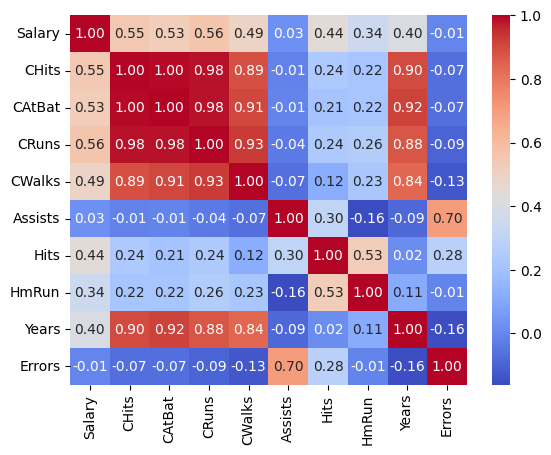

In [3]:
import seaborn as sns

sns.heatmap(hitters_subset.corr(), annot=True, cmap="coolwarm", fmt=".2f");

The heatmap reveals strong correlations between several predictors:

- `CHits` and `CAtBat` show a correlation of 1,
- `CHits` and `CRuns` have a very strong correlation of 0.98,

We thus remove two of the correlated features:

In [4]:
features_drop = ["CRuns", "CAtBat"]
hitters_subset = hitters_subset.drop(columns=features_drop)

## Handling big data in linear models

```{admonition} Handling big data
:class: hint

To handle large datasets efficiently in linear modeling, we will introduce three methods:

- **Subset Selection**
- **Dimensionality Reduction**
- **Regularization / Shrinkage**
```

## Subset Selection
In subset selection we identify a subset of *p* predictos that are truly related to the outcome. The model get fitted using least squares on the reduces set of variables.

How do we determine which variables are relevant?! 

###  Best Subset Selection

We will start with performing Best Subset Selection (also called exhaustive search) as implemented in the `mlxtend` package. It has great documentation, e.g. for the [exhaustive search](https://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/). In short, this approach is a brute-force evaluation of feature subsets. A specific performance metric (e.g. MSE, R², or accuracy) is optimized given an arbitrary regressor or classifier. For example, if we have 4 features, the algorithm will evaluate all 15 possible combinations of features.

In [5]:
from jupyterquiz import display_quiz
display_quiz("quiz/BestSubsetSelection.json", shuffle_answers=True)

<IPython.core.display.Javascript object>

Before we start the subset selection, we first define the target and the features:

In [6]:
import numpy as np

y = hitters_subset["Salary"]
X = hitters_subset.drop("Salary", axis=1)

We first split our data into training and test dataset. Although the selection function uses cross-validation to identify the best subset of predictors (Step 3), this evaluation is done during the selection process and can still overfit to the data. To fairly assess how the final model performs on new data, we split off a test set and use it only after feature selection is complete.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

|Purpose                        	   | What is it for?                                   | When?                                               |
|------------------------------------- |---------------------------------------------------|-----------------------------------------------------|
|Cross Validation in selection function|Helps choose the best subset of features           |During selection                                     |
|Test Set Evaluation                   |Checks how well the final model performs           |After selection                                      |


We then run Best Subset Selection on the training data:

In [8]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector

efs = ExhaustiveFeatureSelector(
        estimator=LinearRegression(),
        min_features=1,
        max_features=X_train.shape[1],
        scoring='r2',
        cv=5,
        print_progress=False)

efs.fit(X_train, y_train)

print('Best R²: %.2f' % efs.best_score_)
print('Best subset (indices):', efs.best_idx_)
print('Best subset (corresponding names):', efs.best_feature_names_)

Best R²: 0.41
Best subset (indices): (1, 3, 4)
Best subset (corresponding names): ('CWalks', 'Hits', 'HmRun')


If you are interested in the details, they are stored in the metric dictionary:

In [9]:
import pandas as pd

df = pd.DataFrame.from_dict(efs.get_metric_dict()).T
df.sort_values('avg_score', inplace=True, ascending=False)
df

feature_idx                                          cv_scores  \
47         (1, 3, 4)  [0.38067374180608526, 0.463839312906159, 0.505...   
90      (1, 3, 4, 6)  [0.3878486031208028, 0.4634739461791568, 0.493...   
83      (1, 2, 3, 4)  [0.3813017586747449, 0.4658246874129488, 0.506...   
89      (1, 3, 4, 5)  [0.33058568684405754, 0.46099452778892, 0.5147...   
114  (1, 2, 3, 4, 6)  [0.3751200780670817, 0.4651398463048052, 0.496...   
..               ...                                                ...   
58         (2, 5, 6)  [0.14956857373046695, 0.13751233647954653, 0.1...   
5               (5,)  [0.14935846878458914, 0.1343083510706763, 0.12...   
2               (2,)  [-0.0025851222923383155, -0.007245558244625583...   
6               (6,)  [-0.02226936534097579, -0.006949819455392525, ...   
21            (2, 6)  [-0.04083051774641855, -0.007183353236134726, ...   

    avg_score                           feature_names  ci_bound   std_dev  \
47   0.412539                   (CWalks, Hits, HmRun)  0.100218  0.077973   
90   0.408445           (CWalks, Hits, HmRun, Errors)  0.094497  0.073522   
83   0.404694          (CWalks, Assists, Hits, HmRun)  0.098463  0.076607   
89   0.403253            (CWalks, Hits, HmRun, Years)  0.105549  0.082121   
114  0.401198  (CWalks, Assists, Hits, HmRun, Errors)  0.095867  0.074588   
..        ...                                     ...       ...       ...   
58   0.122419                (Assists, Years, Errors)  0.120381  0.093661   
5    0.122124                                (Years,)  0.135551  0.105464   
2   -0.040331                              (Assists,)   0.04707  0.036622   
6   -0.051379                               (Errors,)  0.045878  0.035695   
21  -0.057133                       (Assists, Errors)  0.042413  0.032998   

      std_err  
47   0.038987  
90   0.036761  
83   0.038304  
89   0.041061  
114  0.037294  
..        ...  
58    0.04683  
5    0.052732  
2    0.018311  
6    0.017847  
21   0.016499  

[127 rows x 7 columns]

### Forward Stepwise Selection

Forward Stepwise Selection is a greedy feature‐selection method that starts with no features and, at each step, adds the single feature whose inclusion most improves the model’s performance. This “add the best remaining feature” is repeated until a desired number of features is reached, at which point the algorithm stops and returns the best subset.

An important parameter is `k_features`, which determines the number of features to select. We can, pass an integer (must be less than the total number of available features), a tuple (the algorithm will then evaluate all subset sizes between the min and max value), or one of two string options (`"best"`, or `"parsimonious"`). Please refer to the [documentation](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/) for further details.

In [10]:
from mlxtend.feature_selection import SequentialFeatureSelector

sfs_forward = SequentialFeatureSelector(
    estimator=LinearRegression(),
    k_features=(1, X_train.shape[1]),
    forward=True,
    scoring='r2',
    cv=5,
    verbose=0)
    
sfs_forward.fit(X_train, y_train)

print(f">> Forward SFS:")
print(f"   Best CV R²      : {sfs_forward.k_score_:.3f}")
print(f"   Optimal # feats : {len(sfs_forward.k_feature_idx_)}")
print(f"   Feature indices : {sfs_forward.k_feature_idx_}")
print(f"   Feature names   : {sfs_forward.k_feature_names_}")

>> Forward SFS:
   Best CV R²      : 0.413
   Optimal # feats : 3
   Feature indices : (1, 3, 4)
   Feature names   : ('CWalks', 'Hits', 'HmRun')


You can see we ended up with the same three predictors as in best subset selection: `CWalks`, `Hits`, `HmRun`. However, this is not necessarily always the case — best subset and stepwise selection can, and often do, lead to different results. In our case we only had a small number of predictors, which makes it more likely to end up with the same subset.


### Backward Stepwise Selection

Backward Stepwise Selection begins with the full feature set and, at each step, removes the single feature whose exclusion most improves (or least harms) model performance. We keep repeating this “remove the worst feature” step until only the desired number of features remains, and then the algorithm returns that reduced subset:

In [11]:
sfs_backward = SequentialFeatureSelector(
    estimator=LinearRegression(),
    k_features=(1, X_train.shape[1]),
    forward=False,
    floating=False,
    scoring='r2',
    cv=5,
    verbose=0)

sfs_backward.fit(X_train, y_train)

print(f"<< Backward SFS:")
print(f"   Best CV R²      : {sfs_backward.k_score_:.3f}")
print(f"   Optimal # feats : {len(sfs_backward.k_feature_idx_)}")
print(f"   Feature indices : {sfs_backward.k_feature_idx_}")
print(f"   Feature names   : {sfs_backward.k_feature_names_}")

<< Backward SFS:
   Best CV R²      : 0.413
   Optimal # feats : 3
   Feature indices : (1, 3, 4)
   Feature names   : ('CWalks', 'Hits', 'HmRun')


#### Subset Selection Summary

| Best Subset Selection            	  | Forward Stepwise Selection                        | Backward Stepwise Selection                          |
|-------------------------------------|---------------------------------------------------|------------------------------------------------------|
|**+** will find the best model       |**-** not guaranteed to find best model            |**-** not guaranteed to find best model               |
|**-** may overfit with large p       |**+** possible to use when p is very large         |**+** possible to use when p is very large, given p<n |
|**-** computationally very expensive |**+** computationally less demanding               |**+** computationally less demanding                  |

In [12]:
from jupyterquiz import display_quiz
display_quiz('quiz/SubsetSelection.json')

<IPython.core.display.Javascript object>

#### What next?

Once we have identified the features that are relevant for predicting the outcome, let`s evaluate the model performance and estimate true test error with the thee predictors identified by Best Subset Selection and Forward Stepwise Seletion.

In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

selected_features = list(sfs_backward.k_feature_names_)

# Subset the data
X_train_subset = X_train[selected_features]
X_test_subset = X_test[selected_features]

# Fit the model
model = LinearRegression()
model.fit(X_train_subset, y_train)

# Get predictions anf performance
y_pred = model.predict(X_test_subset)

mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred)

print(f"Test MSE:  {mse_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R²:   {r2_test:.4f}")

Test MSE:  182321.00
Test RMSE: 426.99
Test R²:   0.2492


So in sum:

- On average, our predictions deviate from the actual salary by about 426 thousand dollars.
- Our model explains ~25% of the variance in salary.


### Regularization and Dimensionality Reduction

As mentioned before, regularization and dimensionality reduction are two other measures of dealing with large numbers of predictors. Regularization techniques will be introduced in the [next session](2_Regularization), and dimensionality reduction will be introduced in the [Principal Component Analysis](10_PCA) session.